# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

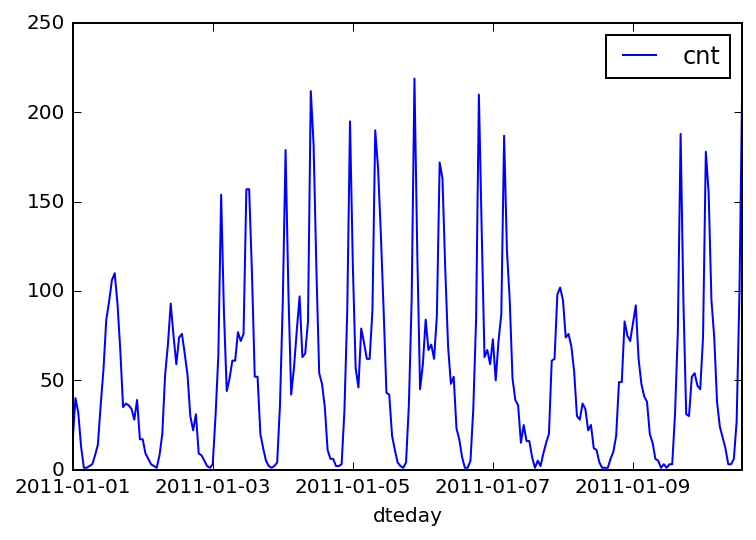

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0.22,0.80,0.0,8,32,40,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0.22,0.80,0.0,5,27,32,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0.24,0.75,0.0,3,10,13,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,0.24,0.75,0.0,0,1,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    # Get the mean and standard deviation of each quant_feature
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    # loc: Access group of values using labels
    # Why use data.loc[:, each]? why not just use data[each]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [12]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
print('N_i:', N_i)
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
    print('X Shape', X.shape)
    print('y Shape', y.shape)
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

N_i: 56
X Shape (128, 56)
y Shape (128,)
Progress: 0.0% ... Training loss: 0.982 ... Validation loss: 1.301X Shape (128, 56)
y Shape (128,)
Progress: 0.0% ... Training loss: 0.925 ... Validation loss: 1.348X Shape (128, 56)
y Shape (128,)
Progress: 0.0% ... Training loss: 0.909 ... Validation loss: 1.309X Shape (128, 56)
y Shape (128,)
Progress: 0.0% ... Training loss: 0.914 ... Validation loss: 1.468X Shape (128, 56)
y Shape (128,)
Progress: 0.0% ... Training loss: 0.938 ... Validation loss: 1.229X Shape (128, 56)
y Shape (128,)
Progress: 0.1% ... Training loss: 1.033 ... Validation loss: 1.775X Shape (128, 56)
y Shape (128,)
Progress: 0.1% ... Training loss: 1.175 ... Validation loss: 1.265X Shape (128, 56)
y Shape (128,)
Progress: 0.1% ... Training loss: 1.340 ... Validation loss: 2.295X Shape (128, 56)
y Shape (128,)
Progress: 0.1% ... Training loss: 0.936 ... Validation loss: 1.187X Shape (128, 56)
y Shape (128,)
Progress: 0.1% ... Training loss: 0.969 ... Validation loss: 1.733X 

Progress: 1.0% ... Training loss: 0.573 ... Validation loss: 1.031X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.569 ... Validation loss: 0.960X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.572 ... Validation loss: 1.035X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.574 ... Validation loss: 1.050X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.584 ... Validation loss: 0.908X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.584 ... Validation loss: 1.084X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.625 ... Validation loss: 0.878X Shape (128, 56)
y Shape (128,)
Progress: 1.0% ... Training loss: 0.571 ... Validation loss: 1.043X Shape (128, 56)
y Shape (128,)
Progress: 1.1% ... Training loss: 0.584 ... Validation loss: 0.888X Shape (128, 56)
y Shape (128,)
Progress: 1.1% ... Training loss: 0.591 ... Validation loss: 1.098X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 1.9% ... Training loss: 0.429 ... Validation loss: 0.711X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.427 ... Validation loss: 0.708X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.426 ... Validation loss: 0.704X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.428 ... Validation loss: 0.712X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.429 ... Validation loss: 0.697X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.424 ... Validation loss: 0.704X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.420 ... Validation loss: 0.694X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.457 ... Validation loss: 0.749X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.456 ... Validation loss: 0.702X Shape (128, 56)
y Shape (128,)
Progress: 2.0% ... Training loss: 0.460 ... Validation loss: 0.754X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 2.9% ... Training loss: 0.378 ... Validation loss: 0.607X Shape (128, 56)
y Shape (128,)
Progress: 2.9% ... Training loss: 0.356 ... Validation loss: 0.565X Shape (128, 56)
y Shape (128,)
Progress: 2.9% ... Training loss: 0.383 ... Validation loss: 0.603X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.374 ... Validation loss: 0.584X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.375 ... Validation loss: 0.591X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.363 ... Validation loss: 0.570X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.412 ... Validation loss: 0.626X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.411 ... Validation loss: 0.618X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.408 ... Validation loss: 0.620X Shape (128, 56)
y Shape (128,)
Progress: 3.0% ... Training loss: 0.380 ... Validation loss: 0.588X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 3.9% ... Training loss: 0.619 ... Validation loss: 0.798X Shape (128, 56)
y Shape (128,)
Progress: 3.9% ... Training loss: 0.424 ... Validation loss: 0.617X Shape (128, 56)
y Shape (128,)
Progress: 3.9% ... Training loss: 0.326 ... Validation loss: 0.516X Shape (128, 56)
y Shape (128,)
Progress: 3.9% ... Training loss: 0.320 ... Validation loss: 0.508X Shape (128, 56)
y Shape (128,)
Progress: 3.9% ... Training loss: 0.308 ... Validation loss: 0.496X Shape (128, 56)
y Shape (128,)
Progress: 4.0% ... Training loss: 0.324 ... Validation loss: 0.513X Shape (128, 56)
y Shape (128,)
Progress: 4.0% ... Training loss: 0.371 ... Validation loss: 0.564X Shape (128, 56)
y Shape (128,)
Progress: 4.0% ... Training loss: 0.498 ... Validation loss: 0.677X Shape (128, 56)
y Shape (128,)
Progress: 4.0% ... Training loss: 0.370 ... Validation loss: 0.558X Shape (128, 56)
y Shape (128,)
Progress: 4.0% ... Training loss: 0.311 ... Validation loss: 0.494X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 4.9% ... Training loss: 0.305 ... Validation loss: 0.498X Shape (128, 56)
y Shape (128,)
Progress: 4.9% ... Training loss: 0.330 ... Validation loss: 0.500X Shape (128, 56)
y Shape (128,)
Progress: 4.9% ... Training loss: 0.297 ... Validation loss: 0.482X Shape (128, 56)
y Shape (128,)
Progress: 4.9% ... Training loss: 0.293 ... Validation loss: 0.473X Shape (128, 56)
y Shape (128,)
Progress: 4.9% ... Training loss: 0.305 ... Validation loss: 0.494X Shape (128, 56)
y Shape (128,)
Progress: 4.9% ... Training loss: 0.300 ... Validation loss: 0.474X Shape (128, 56)
y Shape (128,)
Progress: 4.9% ... Training loss: 0.294 ... Validation loss: 0.476X Shape (128, 56)
y Shape (128,)
Progress: 5.0% ... Training loss: 0.324 ... Validation loss: 0.496X Shape (128, 56)
y Shape (128,)
Progress: 5.0% ... Training loss: 0.316 ... Validation loss: 0.504X Shape (128, 56)
y Shape (128,)
Progress: 5.0% ... Training loss: 0.312 ... Validation loss: 0.486X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 5.8% ... Training loss: 0.307 ... Validation loss: 0.489X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.346 ... Validation loss: 0.514X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.332 ... Validation loss: 0.513X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.305 ... Validation loss: 0.479X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.304 ... Validation loss: 0.478X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.290 ... Validation loss: 0.474X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.285 ... Validation loss: 0.459X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.285 ... Validation loss: 0.459X Shape (128, 56)
y Shape (128,)
Progress: 5.9% ... Training loss: 0.297 ... Validation loss: 0.471X Shape (128, 56)
y Shape (128,)
Progress: 6.0% ... Training loss: 0.288 ... Validation loss: 0.463X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 6.8% ... Training loss: 0.280 ... Validation loss: 0.454X Shape (128, 56)
y Shape (128,)
Progress: 6.8% ... Training loss: 0.303 ... Validation loss: 0.481X Shape (128, 56)
y Shape (128,)
Progress: 6.8% ... Training loss: 0.280 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.287 ... Validation loss: 0.467X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.293 ... Validation loss: 0.466X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.295 ... Validation loss: 0.472X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.285 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.280 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.280 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)
Progress: 6.9% ... Training loss: 0.280 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 7.8% ... Training loss: 0.340 ... Validation loss: 0.511X Shape (128, 56)
y Shape (128,)
Progress: 7.8% ... Training loss: 0.371 ... Validation loss: 0.523X Shape (128, 56)
y Shape (128,)
Progress: 7.8% ... Training loss: 0.354 ... Validation loss: 0.530X Shape (128, 56)
y Shape (128,)
Progress: 7.8% ... Training loss: 0.282 ... Validation loss: 0.450X Shape (128, 56)
y Shape (128,)
Progress: 7.8% ... Training loss: 0.277 ... Validation loss: 0.451X Shape (128, 56)
y Shape (128,)
Progress: 7.9% ... Training loss: 0.293 ... Validation loss: 0.474X Shape (128, 56)
y Shape (128,)
Progress: 7.9% ... Training loss: 0.311 ... Validation loss: 0.481X Shape (128, 56)
y Shape (128,)
Progress: 7.9% ... Training loss: 0.292 ... Validation loss: 0.475X Shape (128, 56)
y Shape (128,)
Progress: 7.9% ... Training loss: 0.280 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)
Progress: 7.9% ... Training loss: 0.287 ... Validation loss: 0.473X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 8.8% ... Training loss: 0.287 ... Validation loss: 0.453X Shape (128, 56)
y Shape (128,)
Progress: 8.8% ... Training loss: 0.286 ... Validation loss: 0.461X Shape (128, 56)
y Shape (128,)
Progress: 8.8% ... Training loss: 0.276 ... Validation loss: 0.448X Shape (128, 56)
y Shape (128,)
Progress: 8.8% ... Training loss: 0.276 ... Validation loss: 0.461X Shape (128, 56)
y Shape (128,)
Progress: 8.8% ... Training loss: 0.290 ... Validation loss: 0.462X Shape (128, 56)
y Shape (128,)
Progress: 8.8% ... Training loss: 0.288 ... Validation loss: 0.478X Shape (128, 56)
y Shape (128,)
Progress: 8.8% ... Training loss: 0.300 ... Validation loss: 0.473X Shape (128, 56)
y Shape (128,)
Progress: 8.9% ... Training loss: 0.276 ... Validation loss: 0.463X Shape (128, 56)
y Shape (128,)
Progress: 8.9% ... Training loss: 0.281 ... Validation loss: 0.462X Shape (128, 56)
y Shape (128,)
Progress: 8.9% ... Training loss: 0.292 ... Validation loss: 0.473X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 9.8% ... Training loss: 0.283 ... Validation loss: 0.459X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.273 ... Validation loss: 0.444X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.273 ... Validation loss: 0.445X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.323 ... Validation loss: 0.486X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.281 ... Validation loss: 0.463X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.295 ... Validation loss: 0.466X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.283 ... Validation loss: 0.462X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.292 ... Validation loss: 0.461X Shape (128, 56)
y Shape (128,)
Progress: 9.8% ... Training loss: 0.276 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 9.9% ... Training loss: 0.271 ... Validation loss: 0.446X Shape (128, 56)
y Shape (128,)
Progress: 

Progress: 10.7% ... Training loss: 0.270 ... Validation loss: 0.443X Shape (128, 56)
y Shape (128,)
Progress: 10.7% ... Training loss: 0.267 ... Validation loss: 0.445X Shape (128, 56)
y Shape (128,)
Progress: 10.7% ... Training loss: 0.268 ... Validation loss: 0.443X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.276 ... Validation loss: 0.454X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.270 ... Validation loss: 0.441X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.270 ... Validation loss: 0.441X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.281 ... Validation loss: 0.449X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.272 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.268 ... Validation loss: 0.449X Shape (128, 56)
y Shape (128,)
Progress: 10.8% ... Training loss: 0.273 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)


Progress: 11.7% ... Training loss: 0.305 ... Validation loss: 0.490X Shape (128, 56)
y Shape (128,)
Progress: 11.7% ... Training loss: 0.272 ... Validation loss: 0.449X Shape (128, 56)
y Shape (128,)
Progress: 11.7% ... Training loss: 0.267 ... Validation loss: 0.451X Shape (128, 56)
y Shape (128,)
Progress: 11.7% ... Training loss: 0.267 ... Validation loss: 0.454X Shape (128, 56)
y Shape (128,)
Progress: 11.7% ... Training loss: 0.269 ... Validation loss: 0.451X Shape (128, 56)
y Shape (128,)
Progress: 11.7% ... Training loss: 0.269 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 11.8% ... Training loss: 0.268 ... Validation loss: 0.455X Shape (128, 56)
y Shape (128,)
Progress: 11.8% ... Training loss: 0.266 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 11.8% ... Training loss: 0.270 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 11.8% ... Training loss: 0.266 ... Validation loss: 0.445X Shape (128, 56)
y Shape (128,)


Progress: 12.6% ... Training loss: 0.264 ... Validation loss: 0.444X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.282 ... Validation loss: 0.456X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.266 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.286 ... Validation loss: 0.461X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.268 ... Validation loss: 0.453X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.271 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.267 ... Validation loss: 0.446X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.268 ... Validation loss: 0.454X Shape (128, 56)
y Shape (128,)
Progress: 12.7% ... Training loss: 0.273 ... Validation loss: 0.453X Shape (128, 56)
y Shape (128,)
Progress: 12.8% ... Training loss: 0.267 ... Validation loss: 0.453X Shape (128, 56)
y Shape (128,)


Progress: 13.6% ... Training loss: 0.270 ... Validation loss: 0.449X Shape (128, 56)
y Shape (128,)
Progress: 13.6% ... Training loss: 0.264 ... Validation loss: 0.439X Shape (128, 56)
y Shape (128,)
Progress: 13.6% ... Training loss: 0.267 ... Validation loss: 0.442X Shape (128, 56)
y Shape (128,)
Progress: 13.6% ... Training loss: 0.265 ... Validation loss: 0.442X Shape (128, 56)
y Shape (128,)
Progress: 13.7% ... Training loss: 0.265 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 13.7% ... Training loss: 0.282 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 13.7% ... Training loss: 0.264 ... Validation loss: 0.438X Shape (128, 56)
y Shape (128,)
Progress: 13.7% ... Training loss: 0.269 ... Validation loss: 0.445X Shape (128, 56)
y Shape (128,)
Progress: 13.7% ... Training loss: 0.263 ... Validation loss: 0.442X Shape (128, 56)
y Shape (128,)
Progress: 13.7% ... Training loss: 0.274 ... Validation loss: 0.447X Shape (128, 56)
y Shape (128,)


Progress: 14.6% ... Training loss: 0.297 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 14.6% ... Training loss: 0.293 ... Validation loss: 0.479X Shape (128, 56)
y Shape (128,)
Progress: 14.6% ... Training loss: 0.269 ... Validation loss: 0.440X Shape (128, 56)
y Shape (128,)
Progress: 14.6% ... Training loss: 0.262 ... Validation loss: 0.441X Shape (128, 56)
y Shape (128,)
Progress: 14.6% ... Training loss: 0.270 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 14.6% ... Training loss: 0.263 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 14.6% ... Training loss: 0.263 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 14.7% ... Training loss: 0.261 ... Validation loss: 0.436X Shape (128, 56)
y Shape (128,)
Progress: 14.7% ... Training loss: 0.261 ... Validation loss: 0.441X Shape (128, 56)
y Shape (128,)
Progress: 14.7% ... Training loss: 0.263 ... Validation loss: 0.447X Shape (128, 56)
y Shape (128,)


Progress: 15.5% ... Training loss: 0.261 ... Validation loss: 0.443X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.261 ... Validation loss: 0.444X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.259 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.267 ... Validation loss: 0.445X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.261 ... Validation loss: 0.434X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.259 ... Validation loss: 0.434X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.266 ... Validation loss: 0.435X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.270 ... Validation loss: 0.440X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.260 ... Validation loss: 0.428X Shape (128, 56)
y Shape (128,)
Progress: 15.6% ... Training loss: 0.268 ... Validation loss: 0.438X Shape (128, 56)
y Shape (128,)


Progress: 16.5% ... Training loss: 0.272 ... Validation loss: 0.450X Shape (128, 56)
y Shape (128,)
Progress: 16.5% ... Training loss: 0.258 ... Validation loss: 0.431X Shape (128, 56)
y Shape (128,)
Progress: 16.5% ... Training loss: 0.261 ... Validation loss: 0.435X Shape (128, 56)
y Shape (128,)
Progress: 16.5% ... Training loss: 0.298 ... Validation loss: 0.484X Shape (128, 56)
y Shape (128,)
Progress: 16.6% ... Training loss: 0.291 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 16.6% ... Training loss: 0.269 ... Validation loss: 0.450X Shape (128, 56)
y Shape (128,)
Progress: 16.6% ... Training loss: 0.261 ... Validation loss: 0.431X Shape (128, 56)
y Shape (128,)
Progress: 16.6% ... Training loss: 0.268 ... Validation loss: 0.446X Shape (128, 56)
y Shape (128,)
Progress: 16.6% ... Training loss: 0.264 ... Validation loss: 0.433X Shape (128, 56)
y Shape (128,)
Progress: 16.6% ... Training loss: 0.259 ... Validation loss: 0.435X Shape (128, 56)
y Shape (128,)


Progress: 17.5% ... Training loss: 0.258 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 17.5% ... Training loss: 0.270 ... Validation loss: 0.438X Shape (128, 56)
y Shape (128,)
Progress: 17.5% ... Training loss: 0.275 ... Validation loss: 0.464X Shape (128, 56)
y Shape (128,)
Progress: 17.5% ... Training loss: 0.271 ... Validation loss: 0.440X Shape (128, 56)
y Shape (128,)
Progress: 17.5% ... Training loss: 0.258 ... Validation loss: 0.443X Shape (128, 56)
y Shape (128,)
Progress: 17.5% ... Training loss: 0.256 ... Validation loss: 0.435X Shape (128, 56)
y Shape (128,)
Progress: 17.5% ... Training loss: 0.257 ... Validation loss: 0.431X Shape (128, 56)
y Shape (128,)
Progress: 17.6% ... Training loss: 0.263 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 17.6% ... Training loss: 0.272 ... Validation loss: 0.454X Shape (128, 56)
y Shape (128,)
Progress: 17.6% ... Training loss: 0.257 ... Validation loss: 0.428X Shape (128, 56)
y Shape (128,)


Progress: 18.4% ... Training loss: 0.259 ... Validation loss: 0.427X Shape (128, 56)
y Shape (128,)
Progress: 18.4% ... Training loss: 0.267 ... Validation loss: 0.435X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.265 ... Validation loss: 0.442X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.268 ... Validation loss: 0.436X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.255 ... Validation loss: 0.429X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.254 ... Validation loss: 0.426X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.261 ... Validation loss: 0.430X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.254 ... Validation loss: 0.426X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.267 ... Validation loss: 0.433X Shape (128, 56)
y Shape (128,)
Progress: 18.5% ... Training loss: 0.260 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)


Progress: 19.4% ... Training loss: 0.273 ... Validation loss: 0.439X Shape (128, 56)
y Shape (128,)
Progress: 19.4% ... Training loss: 0.254 ... Validation loss: 0.428X Shape (128, 56)
y Shape (128,)
Progress: 19.4% ... Training loss: 0.264 ... Validation loss: 0.438X Shape (128, 56)
y Shape (128,)
Progress: 19.4% ... Training loss: 0.272 ... Validation loss: 0.439X Shape (128, 56)
y Shape (128,)
Progress: 19.4% ... Training loss: 0.259 ... Validation loss: 0.438X Shape (128, 56)
y Shape (128,)
Progress: 19.5% ... Training loss: 0.289 ... Validation loss: 0.454X Shape (128, 56)
y Shape (128,)
Progress: 19.5% ... Training loss: 0.273 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 19.5% ... Training loss: 0.272 ... Validation loss: 0.444X Shape (128, 56)
y Shape (128,)
Progress: 19.5% ... Training loss: 0.265 ... Validation loss: 0.449X Shape (128, 56)
y Shape (128,)
Progress: 19.5% ... Training loss: 0.252 ... Validation loss: 0.430X Shape (128, 56)
y Shape (128,)


Progress: 20.4% ... Training loss: 0.251 ... Validation loss: 0.426X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.255 ... Validation loss: 0.430X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.253 ... Validation loss: 0.436X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.250 ... Validation loss: 0.428X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.252 ... Validation loss: 0.427X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.278 ... Validation loss: 0.450X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.288 ... Validation loss: 0.451X Shape (128, 56)
y Shape (128,)
Progress: 20.4% ... Training loss: 0.284 ... Validation loss: 0.457X Shape (128, 56)
y Shape (128,)
Progress: 20.5% ... Training loss: 0.280 ... Validation loss: 0.446X Shape (128, 56)
y Shape (128,)
Progress: 20.5% ... Training loss: 0.253 ... Validation loss: 0.429X Shape (128, 56)
y Shape (128,)


Progress: 21.3% ... Training loss: 0.249 ... Validation loss: 0.424X Shape (128, 56)
y Shape (128,)
Progress: 21.3% ... Training loss: 0.248 ... Validation loss: 0.422X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.271 ... Validation loss: 0.452X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.268 ... Validation loss: 0.431X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.248 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.263 ... Validation loss: 0.450X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.264 ... Validation loss: 0.431X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.251 ... Validation loss: 0.431X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.254 ... Validation loss: 0.433X Shape (128, 56)
y Shape (128,)
Progress: 21.4% ... Training loss: 0.255 ... Validation loss: 0.420X Shape (128, 56)
y Shape (128,)


Progress: 22.3% ... Training loss: 0.249 ... Validation loss: 0.416X Shape (128, 56)
y Shape (128,)
Progress: 22.3% ... Training loss: 0.264 ... Validation loss: 0.427X Shape (128, 56)
y Shape (128,)
Progress: 22.3% ... Training loss: 0.249 ... Validation loss: 0.425X Shape (128, 56)
y Shape (128,)
Progress: 22.3% ... Training loss: 0.264 ... Validation loss: 0.434X Shape (128, 56)
y Shape (128,)
Progress: 22.3% ... Training loss: 0.249 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)
Progress: 22.4% ... Training loss: 0.257 ... Validation loss: 0.429X Shape (128, 56)
y Shape (128,)
Progress: 22.4% ... Training loss: 0.252 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)
Progress: 22.4% ... Training loss: 0.248 ... Validation loss: 0.421X Shape (128, 56)
y Shape (128,)
Progress: 22.4% ... Training loss: 0.252 ... Validation loss: 0.426X Shape (128, 56)
y Shape (128,)
Progress: 22.4% ... Training loss: 0.248 ... Validation loss: 0.422X Shape (128, 56)
y Shape (128,)


Progress: 23.3% ... Training loss: 0.252 ... Validation loss: 0.422X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.258 ... Validation loss: 0.448X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.246 ... Validation loss: 0.417X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.249 ... Validation loss: 0.418X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.249 ... Validation loss: 0.428X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.252 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.248 ... Validation loss: 0.413X Shape (128, 56)
y Shape (128,)
Progress: 23.3% ... Training loss: 0.244 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)
Progress: 23.4% ... Training loss: 0.246 ... Validation loss: 0.410X Shape (128, 56)
y Shape (128,)
Progress: 23.4% ... Training loss: 0.244 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)


Progress: 24.2% ... Training loss: 0.243 ... Validation loss: 0.422X Shape (128, 56)
y Shape (128,)
Progress: 24.2% ... Training loss: 0.243 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)
Progress: 24.2% ... Training loss: 0.246 ... Validation loss: 0.416X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.245 ... Validation loss: 0.426X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.246 ... Validation loss: 0.416X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.248 ... Validation loss: 0.413X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.245 ... Validation loss: 0.424X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.242 ... Validation loss: 0.416X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.242 ... Validation loss: 0.418X Shape (128, 56)
y Shape (128,)
Progress: 24.3% ... Training loss: 0.257 ... Validation loss: 0.413X Shape (128, 56)
y Shape (128,)


Progress: 25.2% ... Training loss: 0.240 ... Validation loss: 0.410X Shape (128, 56)
y Shape (128,)
Progress: 25.2% ... Training loss: 0.239 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 25.2% ... Training loss: 0.239 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 25.2% ... Training loss: 0.241 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)
Progress: 25.2% ... Training loss: 0.243 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 25.2% ... Training loss: 0.245 ... Validation loss: 0.406X Shape (128, 56)
y Shape (128,)
Progress: 25.3% ... Training loss: 0.246 ... Validation loss: 0.415X Shape (128, 56)
y Shape (128,)
Progress: 25.3% ... Training loss: 0.249 ... Validation loss: 0.416X Shape (128, 56)
y Shape (128,)
Progress: 25.3% ... Training loss: 0.247 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 25.3% ... Training loss: 0.244 ... Validation loss: 0.416X Shape (128, 56)
y Shape (128,)


Progress: 26.2% ... Training loss: 0.236 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.241 ... Validation loss: 0.420X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.244 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.243 ... Validation loss: 0.423X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.237 ... Validation loss: 0.409X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.247 ... Validation loss: 0.412X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.237 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.237 ... Validation loss: 0.406X Shape (128, 56)
y Shape (128,)
Progress: 26.2% ... Training loss: 0.245 ... Validation loss: 0.422X Shape (128, 56)
y Shape (128,)
Progress: 26.3% ... Training loss: 0.238 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)


Progress: 27.1% ... Training loss: 0.234 ... Validation loss: 0.401X Shape (128, 56)
y Shape (128,)
Progress: 27.1% ... Training loss: 0.243 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)
Progress: 27.1% ... Training loss: 0.237 ... Validation loss: 0.406X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.235 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.237 ... Validation loss: 0.401X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.240 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.252 ... Validation loss: 0.422X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.234 ... Validation loss: 0.403X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.236 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)
Progress: 27.2% ... Training loss: 0.249 ... Validation loss: 0.410X Shape (128, 56)
y Shape (128,)


Progress: 28.1% ... Training loss: 0.234 ... Validation loss: 0.395X Shape (128, 56)
y Shape (128,)
Progress: 28.1% ... Training loss: 0.235 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)
Progress: 28.1% ... Training loss: 0.232 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 28.1% ... Training loss: 0.236 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 28.1% ... Training loss: 0.233 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)
Progress: 28.1% ... Training loss: 0.232 ... Validation loss: 0.410X Shape (128, 56)
y Shape (128,)
Progress: 28.2% ... Training loss: 0.234 ... Validation loss: 0.404X Shape (128, 56)
y Shape (128,)
Progress: 28.2% ... Training loss: 0.232 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)
Progress: 28.2% ... Training loss: 0.231 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 28.2% ... Training loss: 0.231 ... Validation loss: 0.401X Shape (128, 56)
y Shape (128,)


Progress: 29.0% ... Training loss: 0.228 ... Validation loss: 0.403X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.235 ... Validation loss: 0.399X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.228 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.228 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.229 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.229 ... Validation loss: 0.397X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.229 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.230 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 29.1% ... Training loss: 0.246 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 29.2% ... Training loss: 0.227 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)


Progress: 30.0% ... Training loss: 0.252 ... Validation loss: 0.402X Shape (128, 56)
y Shape (128,)
Progress: 30.0% ... Training loss: 0.239 ... Validation loss: 0.432X Shape (128, 56)
y Shape (128,)
Progress: 30.0% ... Training loss: 0.226 ... Validation loss: 0.397X Shape (128, 56)
y Shape (128,)
Progress: 30.0% ... Training loss: 0.230 ... Validation loss: 0.407X Shape (128, 56)
y Shape (128,)
Progress: 30.1% ... Training loss: 0.247 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)
Progress: 30.1% ... Training loss: 0.226 ... Validation loss: 0.399X Shape (128, 56)
y Shape (128,)
Progress: 30.1% ... Training loss: 0.235 ... Validation loss: 0.394X Shape (128, 56)
y Shape (128,)
Progress: 30.1% ... Training loss: 0.226 ... Validation loss: 0.408X Shape (128, 56)
y Shape (128,)
Progress: 30.1% ... Training loss: 0.234 ... Validation loss: 0.421X Shape (128, 56)
y Shape (128,)
Progress: 30.1% ... Training loss: 0.253 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)


Progress: 31.0% ... Training loss: 0.220 ... Validation loss: 0.398X Shape (128, 56)
y Shape (128,)
Progress: 31.0% ... Training loss: 0.222 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)
Progress: 31.0% ... Training loss: 0.228 ... Validation loss: 0.392X Shape (128, 56)
y Shape (128,)
Progress: 31.0% ... Training loss: 0.233 ... Validation loss: 0.437X Shape (128, 56)
y Shape (128,)
Progress: 31.0% ... Training loss: 0.221 ... Validation loss: 0.394X Shape (128, 56)
y Shape (128,)
Progress: 31.0% ... Training loss: 0.222 ... Validation loss: 0.397X Shape (128, 56)
y Shape (128,)
Progress: 31.0% ... Training loss: 0.226 ... Validation loss: 0.413X Shape (128, 56)
y Shape (128,)
Progress: 31.1% ... Training loss: 0.225 ... Validation loss: 0.411X Shape (128, 56)
y Shape (128,)
Progress: 31.1% ... Training loss: 0.229 ... Validation loss: 0.386X Shape (128, 56)
y Shape (128,)
Progress: 31.1% ... Training loss: 0.234 ... Validation loss: 0.424X Shape (128, 56)
y Shape (128,)


Progress: 31.9% ... Training loss: 0.217 ... Validation loss: 0.393X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.217 ... Validation loss: 0.387X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.223 ... Validation loss: 0.388X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.218 ... Validation loss: 0.392X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.221 ... Validation loss: 0.399X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.220 ... Validation loss: 0.387X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.218 ... Validation loss: 0.396X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.217 ... Validation loss: 0.389X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.223 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 32.0% ... Training loss: 0.218 ... Validation loss: 0.391X Shape (128, 56)
y Shape (128,)


Progress: 32.9% ... Training loss: 0.217 ... Validation loss: 0.384X Shape (128, 56)
y Shape (128,)
Progress: 32.9% ... Training loss: 0.218 ... Validation loss: 0.417X Shape (128, 56)
y Shape (128,)
Progress: 32.9% ... Training loss: 0.214 ... Validation loss: 0.392X Shape (128, 56)
y Shape (128,)
Progress: 32.9% ... Training loss: 0.214 ... Validation loss: 0.384X Shape (128, 56)
y Shape (128,)
Progress: 33.0% ... Training loss: 0.219 ... Validation loss: 0.405X Shape (128, 56)
y Shape (128,)
Progress: 33.0% ... Training loss: 0.213 ... Validation loss: 0.376X Shape (128, 56)
y Shape (128,)
Progress: 33.0% ... Training loss: 0.235 ... Validation loss: 0.378X Shape (128, 56)
y Shape (128,)
Progress: 33.0% ... Training loss: 0.216 ... Validation loss: 0.396X Shape (128, 56)
y Shape (128,)
Progress: 33.0% ... Training loss: 0.212 ... Validation loss: 0.382X Shape (128, 56)
y Shape (128,)
Progress: 33.0% ... Training loss: 0.214 ... Validation loss: 0.396X Shape (128, 56)
y Shape (128,)


Progress: 33.9% ... Training loss: 0.209 ... Validation loss: 0.395X Shape (128, 56)
y Shape (128,)
Progress: 33.9% ... Training loss: 0.210 ... Validation loss: 0.383X Shape (128, 56)
y Shape (128,)
Progress: 33.9% ... Training loss: 0.207 ... Validation loss: 0.383X Shape (128, 56)
y Shape (128,)
Progress: 33.9% ... Training loss: 0.210 ... Validation loss: 0.380X Shape (128, 56)
y Shape (128,)
Progress: 33.9% ... Training loss: 0.207 ... Validation loss: 0.382X Shape (128, 56)
y Shape (128,)
Progress: 33.9% ... Training loss: 0.207 ... Validation loss: 0.381X Shape (128, 56)
y Shape (128,)
Progress: 33.9% ... Training loss: 0.212 ... Validation loss: 0.378X Shape (128, 56)
y Shape (128,)
Progress: 34.0% ... Training loss: 0.214 ... Validation loss: 0.395X Shape (128, 56)
y Shape (128,)
Progress: 34.0% ... Training loss: 0.208 ... Validation loss: 0.375X Shape (128, 56)
y Shape (128,)
Progress: 34.0% ... Training loss: 0.209 ... Validation loss: 0.381X Shape (128, 56)
y Shape (128,)


Progress: 34.8% ... Training loss: 0.203 ... Validation loss: 0.379X Shape (128, 56)
y Shape (128,)
Progress: 34.8% ... Training loss: 0.203 ... Validation loss: 0.369X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.204 ... Validation loss: 0.372X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.204 ... Validation loss: 0.384X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.203 ... Validation loss: 0.380X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.205 ... Validation loss: 0.387X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.212 ... Validation loss: 0.370X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.204 ... Validation loss: 0.385X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.210 ... Validation loss: 0.394X Shape (128, 56)
y Shape (128,)
Progress: 34.9% ... Training loss: 0.204 ... Validation loss: 0.374X Shape (128, 56)
y Shape (128,)


Progress: 35.8% ... Training loss: 0.197 ... Validation loss: 0.373X Shape (128, 56)
y Shape (128,)
Progress: 35.8% ... Training loss: 0.197 ... Validation loss: 0.371X Shape (128, 56)
y Shape (128,)
Progress: 35.8% ... Training loss: 0.198 ... Validation loss: 0.370X Shape (128, 56)
y Shape (128,)
Progress: 35.8% ... Training loss: 0.202 ... Validation loss: 0.366X Shape (128, 56)
y Shape (128,)
Progress: 35.8% ... Training loss: 0.208 ... Validation loss: 0.406X Shape (128, 56)
y Shape (128,)
Progress: 35.9% ... Training loss: 0.202 ... Validation loss: 0.361X Shape (128, 56)
y Shape (128,)
Progress: 35.9% ... Training loss: 0.201 ... Validation loss: 0.361X Shape (128, 56)
y Shape (128,)
Progress: 35.9% ... Training loss: 0.199 ... Validation loss: 0.362X Shape (128, 56)
y Shape (128,)
Progress: 35.9% ... Training loss: 0.203 ... Validation loss: 0.386X Shape (128, 56)
y Shape (128,)
Progress: 35.9% ... Training loss: 0.199 ... Validation loss: 0.374X Shape (128, 56)
y Shape (128,)


Progress: 36.8% ... Training loss: 0.193 ... Validation loss: 0.366X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.196 ... Validation loss: 0.378X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.192 ... Validation loss: 0.357X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.192 ... Validation loss: 0.361X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.192 ... Validation loss: 0.366X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.192 ... Validation loss: 0.365X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.203 ... Validation loss: 0.354X Shape (128, 56)
y Shape (128,)
Progress: 36.8% ... Training loss: 0.193 ... Validation loss: 0.354X Shape (128, 56)
y Shape (128,)
Progress: 36.9% ... Training loss: 0.198 ... Validation loss: 0.354X Shape (128, 56)
y Shape (128,)
Progress: 36.9% ... Training loss: 0.195 ... Validation loss: 0.373X Shape (128, 56)
y Shape (128,)


Progress: 37.7% ... Training loss: 0.192 ... Validation loss: 0.351X Shape (128, 56)
y Shape (128,)
Progress: 37.7% ... Training loss: 0.189 ... Validation loss: 0.379X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.190 ... Validation loss: 0.357X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.188 ... Validation loss: 0.373X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.190 ... Validation loss: 0.379X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.187 ... Validation loss: 0.351X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.189 ... Validation loss: 0.379X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.186 ... Validation loss: 0.360X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.186 ... Validation loss: 0.357X Shape (128, 56)
y Shape (128,)
Progress: 37.8% ... Training loss: 0.190 ... Validation loss: 0.344X Shape (128, 56)
y Shape (128,)


Progress: 38.7% ... Training loss: 0.180 ... Validation loss: 0.339X Shape (128, 56)
y Shape (128,)
Progress: 38.7% ... Training loss: 0.183 ... Validation loss: 0.350X Shape (128, 56)
y Shape (128,)
Progress: 38.7% ... Training loss: 0.182 ... Validation loss: 0.349X Shape (128, 56)
y Shape (128,)
Progress: 38.7% ... Training loss: 0.187 ... Validation loss: 0.365X Shape (128, 56)
y Shape (128,)
Progress: 38.7% ... Training loss: 0.196 ... Validation loss: 0.335X Shape (128, 56)
y Shape (128,)
Progress: 38.8% ... Training loss: 0.188 ... Validation loss: 0.379X Shape (128, 56)
y Shape (128,)
Progress: 38.8% ... Training loss: 0.190 ... Validation loss: 0.334X Shape (128, 56)
y Shape (128,)
Progress: 38.8% ... Training loss: 0.197 ... Validation loss: 0.386X Shape (128, 56)
y Shape (128,)
Progress: 38.8% ... Training loss: 0.188 ... Validation loss: 0.332X Shape (128, 56)
y Shape (128,)
Progress: 38.8% ... Training loss: 0.180 ... Validation loss: 0.342X Shape (128, 56)
y Shape (128,)


Progress: 39.7% ... Training loss: 0.177 ... Validation loss: 0.333X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.173 ... Validation loss: 0.341X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.173 ... Validation loss: 0.343X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.176 ... Validation loss: 0.335X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.173 ... Validation loss: 0.340X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.179 ... Validation loss: 0.333X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.178 ... Validation loss: 0.366X Shape (128, 56)
y Shape (128,)
Progress: 39.7% ... Training loss: 0.184 ... Validation loss: 0.331X Shape (128, 56)
y Shape (128,)
Progress: 39.8% ... Training loss: 0.173 ... Validation loss: 0.346X Shape (128, 56)
y Shape (128,)
Progress: 39.8% ... Training loss: 0.175 ... Validation loss: 0.334X Shape (128, 56)
y Shape (128,)


Progress: 40.6% ... Training loss: 0.169 ... Validation loss: 0.335X Shape (128, 56)
y Shape (128,)
Progress: 40.6% ... Training loss: 0.170 ... Validation loss: 0.347X Shape (128, 56)
y Shape (128,)
Progress: 40.6% ... Training loss: 0.171 ... Validation loss: 0.331X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.180 ... Validation loss: 0.375X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.168 ... Validation loss: 0.335X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.170 ... Validation loss: 0.329X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.169 ... Validation loss: 0.330X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.173 ... Validation loss: 0.355X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.175 ... Validation loss: 0.324X Shape (128, 56)
y Shape (128,)
Progress: 40.7% ... Training loss: 0.174 ... Validation loss: 0.355X Shape (128, 56)
y Shape (128,)


Progress: 41.6% ... Training loss: 0.166 ... Validation loss: 0.311X Shape (128, 56)
y Shape (128,)
Progress: 41.6% ... Training loss: 0.161 ... Validation loss: 0.325X Shape (128, 56)
y Shape (128,)
Progress: 41.6% ... Training loss: 0.160 ... Validation loss: 0.322X Shape (128, 56)
y Shape (128,)
Progress: 41.6% ... Training loss: 0.160 ... Validation loss: 0.321X Shape (128, 56)
y Shape (128,)
Progress: 41.6% ... Training loss: 0.160 ... Validation loss: 0.318X Shape (128, 56)
y Shape (128,)
Progress: 41.6% ... Training loss: 0.160 ... Validation loss: 0.317X Shape (128, 56)
y Shape (128,)
Progress: 41.7% ... Training loss: 0.161 ... Validation loss: 0.313X Shape (128, 56)
y Shape (128,)
Progress: 41.7% ... Training loss: 0.167 ... Validation loss: 0.334X Shape (128, 56)
y Shape (128,)
Progress: 41.7% ... Training loss: 0.164 ... Validation loss: 0.309X Shape (128, 56)
y Shape (128,)
Progress: 41.7% ... Training loss: 0.160 ... Validation loss: 0.319X Shape (128, 56)
y Shape (128,)


Progress: 42.6% ... Training loss: 0.156 ... Validation loss: 0.313X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.159 ... Validation loss: 0.317X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.160 ... Validation loss: 0.298X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.167 ... Validation loss: 0.331X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.155 ... Validation loss: 0.303X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.156 ... Validation loss: 0.309X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.155 ... Validation loss: 0.301X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.154 ... Validation loss: 0.305X Shape (128, 56)
y Shape (128,)
Progress: 42.6% ... Training loss: 0.157 ... Validation loss: 0.301X Shape (128, 56)
y Shape (128,)
Progress: 42.7% ... Training loss: 0.162 ... Validation loss: 0.327X Shape (128, 56)
y Shape (128,)


Progress: 43.5% ... Training loss: 0.149 ... Validation loss: 0.313X Shape (128, 56)
y Shape (128,)
Progress: 43.5% ... Training loss: 0.148 ... Validation loss: 0.311X Shape (128, 56)
y Shape (128,)
Progress: 43.5% ... Training loss: 0.149 ... Validation loss: 0.303X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.152 ... Validation loss: 0.323X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.149 ... Validation loss: 0.314X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.148 ... Validation loss: 0.309X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.149 ... Validation loss: 0.317X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.150 ... Validation loss: 0.297X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.157 ... Validation loss: 0.325X Shape (128, 56)
y Shape (128,)
Progress: 43.6% ... Training loss: 0.148 ... Validation loss: 0.306X Shape (128, 56)
y Shape (128,)


Progress: 44.5% ... Training loss: 0.143 ... Validation loss: 0.301X Shape (128, 56)
y Shape (128,)
Progress: 44.5% ... Training loss: 0.150 ... Validation loss: 0.317X Shape (128, 56)
y Shape (128,)
Progress: 44.5% ... Training loss: 0.143 ... Validation loss: 0.288X Shape (128, 56)
y Shape (128,)
Progress: 44.5% ... Training loss: 0.143 ... Validation loss: 0.291X Shape (128, 56)
y Shape (128,)
Progress: 44.5% ... Training loss: 0.144 ... Validation loss: 0.310X Shape (128, 56)
y Shape (128,)
Progress: 44.5% ... Training loss: 0.145 ... Validation loss: 0.286X Shape (128, 56)
y Shape (128,)
Progress: 44.6% ... Training loss: 0.144 ... Validation loss: 0.289X Shape (128, 56)
y Shape (128,)
Progress: 44.6% ... Training loss: 0.142 ... Validation loss: 0.302X Shape (128, 56)
y Shape (128,)
Progress: 44.6% ... Training loss: 0.142 ... Validation loss: 0.302X Shape (128, 56)
y Shape (128,)
Progress: 44.6% ... Training loss: 0.142 ... Validation loss: 0.300X Shape (128, 56)
y Shape (128,)


Progress: 45.4% ... Training loss: 0.138 ... Validation loss: 0.289X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.138 ... Validation loss: 0.278X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.137 ... Validation loss: 0.285X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.136 ... Validation loss: 0.280X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.136 ... Validation loss: 0.278X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.136 ... Validation loss: 0.276X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.138 ... Validation loss: 0.276X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.140 ... Validation loss: 0.291X Shape (128, 56)
y Shape (128,)
Progress: 45.5% ... Training loss: 0.138 ... Validation loss: 0.273X Shape (128, 56)
y Shape (128,)
Progress: 45.6% ... Training loss: 0.136 ... Validation loss: 0.279X Shape (128, 56)
y Shape (128,)


Progress: 46.4% ... Training loss: 0.135 ... Validation loss: 0.265X Shape (128, 56)
y Shape (128,)
Progress: 46.4% ... Training loss: 0.132 ... Validation loss: 0.270X Shape (128, 56)
y Shape (128,)
Progress: 46.4% ... Training loss: 0.131 ... Validation loss: 0.275X Shape (128, 56)
y Shape (128,)
Progress: 46.4% ... Training loss: 0.131 ... Validation loss: 0.274X Shape (128, 56)
y Shape (128,)
Progress: 46.5% ... Training loss: 0.130 ... Validation loss: 0.270X Shape (128, 56)
y Shape (128,)
Progress: 46.5% ... Training loss: 0.131 ... Validation loss: 0.275X Shape (128, 56)
y Shape (128,)
Progress: 46.5% ... Training loss: 0.134 ... Validation loss: 0.266X Shape (128, 56)
y Shape (128,)
Progress: 46.5% ... Training loss: 0.131 ... Validation loss: 0.275X Shape (128, 56)
y Shape (128,)
Progress: 46.5% ... Training loss: 0.136 ... Validation loss: 0.291X Shape (128, 56)
y Shape (128,)
Progress: 46.5% ... Training loss: 0.130 ... Validation loss: 0.273X Shape (128, 56)
y Shape (128,)


Progress: 47.4% ... Training loss: 0.128 ... Validation loss: 0.258X Shape (128, 56)
y Shape (128,)
Progress: 47.4% ... Training loss: 0.127 ... Validation loss: 0.256X Shape (128, 56)
y Shape (128,)
Progress: 47.4% ... Training loss: 0.129 ... Validation loss: 0.252X Shape (128, 56)
y Shape (128,)
Progress: 47.4% ... Training loss: 0.126 ... Validation loss: 0.262X Shape (128, 56)
y Shape (128,)
Progress: 47.4% ... Training loss: 0.125 ... Validation loss: 0.256X Shape (128, 56)
y Shape (128,)
Progress: 47.4% ... Training loss: 0.129 ... Validation loss: 0.255X Shape (128, 56)
y Shape (128,)
Progress: 47.4% ... Training loss: 0.132 ... Validation loss: 0.273X Shape (128, 56)
y Shape (128,)
Progress: 47.5% ... Training loss: 0.125 ... Validation loss: 0.258X Shape (128, 56)
y Shape (128,)
Progress: 47.5% ... Training loss: 0.126 ... Validation loss: 0.265X Shape (128, 56)
y Shape (128,)
Progress: 47.5% ... Training loss: 0.131 ... Validation loss: 0.252X Shape (128, 56)
y Shape (128,)


Progress: 48.3% ... Training loss: 0.121 ... Validation loss: 0.255X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.132 ... Validation loss: 0.283X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.123 ... Validation loss: 0.249X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.121 ... Validation loss: 0.264X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.124 ... Validation loss: 0.266X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.122 ... Validation loss: 0.247X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.123 ... Validation loss: 0.244X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.125 ... Validation loss: 0.244X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.121 ... Validation loss: 0.259X Shape (128, 56)
y Shape (128,)
Progress: 48.4% ... Training loss: 0.122 ... Validation loss: 0.246X Shape (128, 56)
y Shape (128,)


Progress: 49.3% ... Training loss: 0.129 ... Validation loss: 0.245X Shape (128, 56)
y Shape (128,)
Progress: 49.3% ... Training loss: 0.121 ... Validation loss: 0.258X Shape (128, 56)
y Shape (128,)
Progress: 49.3% ... Training loss: 0.116 ... Validation loss: 0.245X Shape (128, 56)
y Shape (128,)
Progress: 49.3% ... Training loss: 0.117 ... Validation loss: 0.244X Shape (128, 56)
y Shape (128,)
Progress: 49.4% ... Training loss: 0.116 ... Validation loss: 0.245X Shape (128, 56)
y Shape (128,)
Progress: 49.4% ... Training loss: 0.119 ... Validation loss: 0.259X Shape (128, 56)
y Shape (128,)
Progress: 49.4% ... Training loss: 0.115 ... Validation loss: 0.251X Shape (128, 56)
y Shape (128,)
Progress: 49.4% ... Training loss: 0.116 ... Validation loss: 0.249X Shape (128, 56)
y Shape (128,)
Progress: 49.4% ... Training loss: 0.116 ... Validation loss: 0.239X Shape (128, 56)
y Shape (128,)
Progress: 49.4% ... Training loss: 0.115 ... Validation loss: 0.243X Shape (128, 56)
y Shape (128,)


Progress: 50.3% ... Training loss: 0.114 ... Validation loss: 0.239X Shape (128, 56)
y Shape (128,)
Progress: 50.3% ... Training loss: 0.115 ... Validation loss: 0.267X Shape (128, 56)
y Shape (128,)
Progress: 50.3% ... Training loss: 0.111 ... Validation loss: 0.246X Shape (128, 56)
y Shape (128,)
Progress: 50.3% ... Training loss: 0.113 ... Validation loss: 0.258X Shape (128, 56)
y Shape (128,)
Progress: 50.3% ... Training loss: 0.111 ... Validation loss: 0.243X Shape (128, 56)
y Shape (128,)
Progress: 50.3% ... Training loss: 0.114 ... Validation loss: 0.239X Shape (128, 56)
y Shape (128,)
Progress: 50.3% ... Training loss: 0.111 ... Validation loss: 0.245X Shape (128, 56)
y Shape (128,)
Progress: 50.4% ... Training loss: 0.111 ... Validation loss: 0.245X Shape (128, 56)
y Shape (128,)
Progress: 50.4% ... Training loss: 0.116 ... Validation loss: 0.235X Shape (128, 56)
y Shape (128,)
Progress: 50.4% ... Training loss: 0.112 ... Validation loss: 0.258X Shape (128, 56)
y Shape (128,)


Progress: 51.2% ... Training loss: 0.116 ... Validation loss: 0.226X Shape (128, 56)
y Shape (128,)
Progress: 51.2% ... Training loss: 0.107 ... Validation loss: 0.234X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.107 ... Validation loss: 0.234X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.108 ... Validation loss: 0.241X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.114 ... Validation loss: 0.226X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.116 ... Validation loss: 0.259X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.110 ... Validation loss: 0.225X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.107 ... Validation loss: 0.236X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.107 ... Validation loss: 0.234X Shape (128, 56)
y Shape (128,)
Progress: 51.3% ... Training loss: 0.118 ... Validation loss: 0.226X Shape (128, 56)
y Shape (128,)


Progress: 52.2% ... Training loss: 0.104 ... Validation loss: 0.218X Shape (128, 56)
y Shape (128,)
Progress: 52.2% ... Training loss: 0.104 ... Validation loss: 0.215X Shape (128, 56)
y Shape (128,)
Progress: 52.2% ... Training loss: 0.104 ... Validation loss: 0.213X Shape (128, 56)
y Shape (128,)
Progress: 52.2% ... Training loss: 0.104 ... Validation loss: 0.215X Shape (128, 56)
y Shape (128,)
Progress: 52.2% ... Training loss: 0.106 ... Validation loss: 0.223X Shape (128, 56)
y Shape (128,)
Progress: 52.3% ... Training loss: 0.104 ... Validation loss: 0.211X Shape (128, 56)
y Shape (128,)
Progress: 52.3% ... Training loss: 0.108 ... Validation loss: 0.228X Shape (128, 56)
y Shape (128,)
Progress: 52.3% ... Training loss: 0.106 ... Validation loss: 0.213X Shape (128, 56)
y Shape (128,)
Progress: 52.3% ... Training loss: 0.110 ... Validation loss: 0.213X Shape (128, 56)
y Shape (128,)
Progress: 52.3% ... Training loss: 0.110 ... Validation loss: 0.235X Shape (128, 56)
y Shape (128,)


Progress: 53.2% ... Training loss: 0.101 ... Validation loss: 0.218X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.114 ... Validation loss: 0.241X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.100 ... Validation loss: 0.217X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.100 ... Validation loss: 0.216X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.100 ... Validation loss: 0.219X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.102 ... Validation loss: 0.230X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.101 ... Validation loss: 0.208X Shape (128, 56)
y Shape (128,)
Progress: 53.2% ... Training loss: 0.099 ... Validation loss: 0.214X Shape (128, 56)
y Shape (128,)
Progress: 53.3% ... Training loss: 0.101 ... Validation loss: 0.222X Shape (128, 56)
y Shape (128,)
Progress: 53.3% ... Training loss: 0.101 ... Validation loss: 0.223X Shape (128, 56)
y Shape (128,)


Progress: 54.1% ... Training loss: 0.099 ... Validation loss: 0.209X Shape (128, 56)
y Shape (128,)
Progress: 54.1% ... Training loss: 0.097 ... Validation loss: 0.218X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.097 ... Validation loss: 0.210X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.097 ... Validation loss: 0.212X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.099 ... Validation loss: 0.223X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.096 ... Validation loss: 0.217X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.097 ... Validation loss: 0.221X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.096 ... Validation loss: 0.217X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.099 ... Validation loss: 0.226X Shape (128, 56)
y Shape (128,)
Progress: 54.2% ... Training loss: 0.098 ... Validation loss: 0.209X Shape (128, 56)
y Shape (128,)


Progress: 55.1% ... Training loss: 0.095 ... Validation loss: 0.203X Shape (128, 56)
y Shape (128,)
Progress: 55.1% ... Training loss: 0.094 ... Validation loss: 0.210X Shape (128, 56)
y Shape (128,)
Progress: 55.1% ... Training loss: 0.095 ... Validation loss: 0.201X Shape (128, 56)
y Shape (128,)
Progress: 55.1% ... Training loss: 0.095 ... Validation loss: 0.210X Shape (128, 56)
y Shape (128,)
Progress: 55.1% ... Training loss: 0.094 ... Validation loss: 0.206X Shape (128, 56)
y Shape (128,)
Progress: 55.2% ... Training loss: 0.094 ... Validation loss: 0.208X Shape (128, 56)
y Shape (128,)
Progress: 55.2% ... Training loss: 0.098 ... Validation loss: 0.202X Shape (128, 56)
y Shape (128,)
Progress: 55.2% ... Training loss: 0.095 ... Validation loss: 0.213X Shape (128, 56)
y Shape (128,)
Progress: 55.2% ... Training loss: 0.093 ... Validation loss: 0.205X Shape (128, 56)
y Shape (128,)
Progress: 55.2% ... Training loss: 0.098 ... Validation loss: 0.200X Shape (128, 56)
y Shape (128,)


Progress: 56.1% ... Training loss: 0.094 ... Validation loss: 0.213X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.092 ... Validation loss: 0.194X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.091 ... Validation loss: 0.205X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.092 ... Validation loss: 0.206X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.096 ... Validation loss: 0.197X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.091 ... Validation loss: 0.202X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.092 ... Validation loss: 0.213X Shape (128, 56)
y Shape (128,)
Progress: 56.1% ... Training loss: 0.092 ... Validation loss: 0.199X Shape (128, 56)
y Shape (128,)
Progress: 56.2% ... Training loss: 0.096 ... Validation loss: 0.220X Shape (128, 56)
y Shape (128,)
Progress: 56.2% ... Training loss: 0.091 ... Validation loss: 0.203X Shape (128, 56)
y Shape (128,)


Progress: 57.0% ... Training loss: 0.090 ... Validation loss: 0.193X Shape (128, 56)
y Shape (128,)
Progress: 57.0% ... Training loss: 0.089 ... Validation loss: 0.199X Shape (128, 56)
y Shape (128,)
Progress: 57.0% ... Training loss: 0.089 ... Validation loss: 0.201X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.101 ... Validation loss: 0.235X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.094 ... Validation loss: 0.189X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.089 ... Validation loss: 0.205X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.090 ... Validation loss: 0.192X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.093 ... Validation loss: 0.219X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.089 ... Validation loss: 0.196X Shape (128, 56)
y Shape (128,)
Progress: 57.1% ... Training loss: 0.088 ... Validation loss: 0.203X Shape (128, 56)
y Shape (128,)


Progress: 58.0% ... Training loss: 0.087 ... Validation loss: 0.201X Shape (128, 56)
y Shape (128,)
Progress: 58.0% ... Training loss: 0.088 ... Validation loss: 0.191X Shape (128, 56)
y Shape (128,)
Progress: 58.0% ... Training loss: 0.086 ... Validation loss: 0.194X Shape (128, 56)
y Shape (128,)
Progress: 58.0% ... Training loss: 0.089 ... Validation loss: 0.202X Shape (128, 56)
y Shape (128,)
Progress: 58.0% ... Training loss: 0.086 ... Validation loss: 0.191X Shape (128, 56)
y Shape (128,)
Progress: 58.0% ... Training loss: 0.088 ... Validation loss: 0.187X Shape (128, 56)
y Shape (128,)
Progress: 58.1% ... Training loss: 0.086 ... Validation loss: 0.191X Shape (128, 56)
y Shape (128,)
Progress: 58.1% ... Training loss: 0.087 ... Validation loss: 0.187X Shape (128, 56)
y Shape (128,)
Progress: 58.1% ... Training loss: 0.088 ... Validation loss: 0.185X Shape (128, 56)
y Shape (128,)
Progress: 58.1% ... Training loss: 0.088 ... Validation loss: 0.202X Shape (128, 56)
y Shape (128,)


Progress: 59.0% ... Training loss: 0.086 ... Validation loss: 0.191X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.086 ... Validation loss: 0.190X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.086 ... Validation loss: 0.192X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.087 ... Validation loss: 0.180X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.087 ... Validation loss: 0.181X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.084 ... Validation loss: 0.184X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.084 ... Validation loss: 0.188X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.085 ... Validation loss: 0.186X Shape (128, 56)
y Shape (128,)
Progress: 59.0% ... Training loss: 0.089 ... Validation loss: 0.184X Shape (128, 56)
y Shape (128,)
Progress: 59.1% ... Training loss: 0.085 ... Validation loss: 0.197X Shape (128, 56)
y Shape (128,)


Progress: 59.9% ... Training loss: 0.082 ... Validation loss: 0.183X Shape (128, 56)
y Shape (128,)
Progress: 59.9% ... Training loss: 0.088 ... Validation loss: 0.198X Shape (128, 56)
y Shape (128,)
Progress: 59.9% ... Training loss: 0.093 ... Validation loss: 0.174X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.083 ... Validation loss: 0.186X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.084 ... Validation loss: 0.182X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.082 ... Validation loss: 0.183X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.083 ... Validation loss: 0.189X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.084 ... Validation loss: 0.177X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.083 ... Validation loss: 0.187X Shape (128, 56)
y Shape (128,)
Progress: 60.0% ... Training loss: 0.083 ... Validation loss: 0.188X Shape (128, 56)
y Shape (128,)


Progress: 60.9% ... Training loss: 0.081 ... Validation loss: 0.178X Shape (128, 56)
y Shape (128,)
Progress: 60.9% ... Training loss: 0.083 ... Validation loss: 0.195X Shape (128, 56)
y Shape (128,)
Progress: 60.9% ... Training loss: 0.082 ... Validation loss: 0.189X Shape (128, 56)
y Shape (128,)
Progress: 60.9% ... Training loss: 0.081 ... Validation loss: 0.185X Shape (128, 56)
y Shape (128,)
Progress: 60.9% ... Training loss: 0.083 ... Validation loss: 0.191X Shape (128, 56)
y Shape (128,)
Progress: 60.9% ... Training loss: 0.081 ... Validation loss: 0.185X Shape (128, 56)
y Shape (128,)
Progress: 61.0% ... Training loss: 0.083 ... Validation loss: 0.172X Shape (128, 56)
y Shape (128,)
Progress: 61.0% ... Training loss: 0.081 ... Validation loss: 0.182X Shape (128, 56)
y Shape (128,)
Progress: 61.0% ... Training loss: 0.081 ... Validation loss: 0.177X Shape (128, 56)
y Shape (128,)
Progress: 61.0% ... Training loss: 0.083 ... Validation loss: 0.188X Shape (128, 56)
y Shape (128,)


Progress: 61.8% ... Training loss: 0.081 ... Validation loss: 0.175X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.079 ... Validation loss: 0.185X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.079 ... Validation loss: 0.177X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.081 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.084 ... Validation loss: 0.201X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.081 ... Validation loss: 0.175X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.079 ... Validation loss: 0.181X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.080 ... Validation loss: 0.188X Shape (128, 56)
y Shape (128,)
Progress: 61.9% ... Training loss: 0.079 ... Validation loss: 0.176X Shape (128, 56)
y Shape (128,)
Progress: 62.0% ... Training loss: 0.079 ... Validation loss: 0.183X Shape (128, 56)
y Shape (128,)


Progress: 62.8% ... Training loss: 0.078 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)
Progress: 62.8% ... Training loss: 0.084 ... Validation loss: 0.197X Shape (128, 56)
y Shape (128,)
Progress: 62.8% ... Training loss: 0.078 ... Validation loss: 0.175X Shape (128, 56)
y Shape (128,)
Progress: 62.8% ... Training loss: 0.078 ... Validation loss: 0.187X Shape (128, 56)
y Shape (128,)
Progress: 62.9% ... Training loss: 0.079 ... Validation loss: 0.174X Shape (128, 56)
y Shape (128,)
Progress: 62.9% ... Training loss: 0.081 ... Validation loss: 0.192X Shape (128, 56)
y Shape (128,)
Progress: 62.9% ... Training loss: 0.081 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 62.9% ... Training loss: 0.077 ... Validation loss: 0.177X Shape (128, 56)
y Shape (128,)
Progress: 62.9% ... Training loss: 0.081 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 62.9% ... Training loss: 0.078 ... Validation loss: 0.175X Shape (128, 56)
y Shape (128,)


Progress: 63.8% ... Training loss: 0.077 ... Validation loss: 0.180X Shape (128, 56)
y Shape (128,)
Progress: 63.8% ... Training loss: 0.077 ... Validation loss: 0.178X Shape (128, 56)
y Shape (128,)
Progress: 63.8% ... Training loss: 0.078 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 63.8% ... Training loss: 0.080 ... Validation loss: 0.182X Shape (128, 56)
y Shape (128,)
Progress: 63.8% ... Training loss: 0.077 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 63.8% ... Training loss: 0.077 ... Validation loss: 0.182X Shape (128, 56)
y Shape (128,)
Progress: 63.8% ... Training loss: 0.079 ... Validation loss: 0.169X Shape (128, 56)
y Shape (128,)
Progress: 63.9% ... Training loss: 0.077 ... Validation loss: 0.184X Shape (128, 56)
y Shape (128,)
Progress: 63.9% ... Training loss: 0.079 ... Validation loss: 0.169X Shape (128, 56)
y Shape (128,)
Progress: 63.9% ... Training loss: 0.077 ... Validation loss: 0.179X Shape (128, 56)
y Shape (128,)


Progress: 64.7% ... Training loss: 0.076 ... Validation loss: 0.175X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.076 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.075 ... Validation loss: 0.168X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.075 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.076 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.077 ... Validation loss: 0.172X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.075 ... Validation loss: 0.172X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.083 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.080 ... Validation loss: 0.189X Shape (128, 56)
y Shape (128,)
Progress: 64.8% ... Training loss: 0.075 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)


Progress: 65.7% ... Training loss: 0.074 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 65.7% ... Training loss: 0.074 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 65.7% ... Training loss: 0.074 ... Validation loss: 0.172X Shape (128, 56)
y Shape (128,)
Progress: 65.7% ... Training loss: 0.074 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)
Progress: 65.8% ... Training loss: 0.074 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 65.8% ... Training loss: 0.075 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 65.8% ... Training loss: 0.074 ... Validation loss: 0.169X Shape (128, 56)
y Shape (128,)
Progress: 65.8% ... Training loss: 0.074 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 65.8% ... Training loss: 0.074 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)
Progress: 65.8% ... Training loss: 0.074 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)


Progress: 66.7% ... Training loss: 0.077 ... Validation loss: 0.183X Shape (128, 56)
y Shape (128,)
Progress: 66.7% ... Training loss: 0.073 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 66.7% ... Training loss: 0.073 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)
Progress: 66.7% ... Training loss: 0.075 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 66.7% ... Training loss: 0.074 ... Validation loss: 0.172X Shape (128, 56)
y Shape (128,)
Progress: 66.7% ... Training loss: 0.075 ... Validation loss: 0.169X Shape (128, 56)
y Shape (128,)
Progress: 66.7% ... Training loss: 0.074 ... Validation loss: 0.176X Shape (128, 56)
y Shape (128,)
Progress: 66.8% ... Training loss: 0.074 ... Validation loss: 0.177X Shape (128, 56)
y Shape (128,)
Progress: 66.8% ... Training loss: 0.076 ... Validation loss: 0.182X Shape (128, 56)
y Shape (128,)
Progress: 66.8% ... Training loss: 0.076 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)


Progress: 67.6% ... Training loss: 0.072 ... Validation loss: 0.169X Shape (128, 56)
y Shape (128,)
Progress: 67.6% ... Training loss: 0.075 ... Validation loss: 0.185X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.073 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.074 ... Validation loss: 0.181X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.072 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.073 ... Validation loss: 0.180X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.074 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.072 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.074 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 67.7% ... Training loss: 0.073 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)


Progress: 68.6% ... Training loss: 0.072 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 68.6% ... Training loss: 0.072 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 68.6% ... Training loss: 0.072 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 68.6% ... Training loss: 0.074 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)
Progress: 68.6% ... Training loss: 0.072 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 68.7% ... Training loss: 0.073 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 68.7% ... Training loss: 0.073 ... Validation loss: 0.168X Shape (128, 56)
y Shape (128,)
Progress: 68.7% ... Training loss: 0.071 ... Validation loss: 0.168X Shape (128, 56)
y Shape (128,)
Progress: 68.7% ... Training loss: 0.073 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 68.7% ... Training loss: 0.078 ... Validation loss: 0.184X Shape (128, 56)
y Shape (128,)


Progress: 69.6% ... Training loss: 0.075 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.075 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.077 ... Validation loss: 0.184X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.073 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.075 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.074 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.077 ... Validation loss: 0.176X Shape (128, 56)
y Shape (128,)
Progress: 69.6% ... Training loss: 0.079 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 69.7% ... Training loss: 0.072 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 69.7% ... Training loss: 0.071 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)


Progress: 70.5% ... Training loss: 0.070 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)
Progress: 70.5% ... Training loss: 0.070 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.071 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.070 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.071 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.075 ... Validation loss: 0.179X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.082 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.073 ... Validation loss: 0.181X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.072 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)
Progress: 70.6% ... Training loss: 0.075 ... Validation loss: 0.193X Shape (128, 56)
y Shape (128,)


Progress: 71.5% ... Training loss: 0.072 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 71.5% ... Training loss: 0.075 ... Validation loss: 0.187X Shape (128, 56)
y Shape (128,)
Progress: 71.5% ... Training loss: 0.070 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 71.5% ... Training loss: 0.069 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 71.5% ... Training loss: 0.070 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 71.6% ... Training loss: 0.072 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 71.6% ... Training loss: 0.069 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 71.6% ... Training loss: 0.070 ... Validation loss: 0.176X Shape (128, 56)
y Shape (128,)
Progress: 71.6% ... Training loss: 0.069 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 71.6% ... Training loss: 0.069 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)


Progress: 72.5% ... Training loss: 0.069 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.068 ... Validation loss: 0.160X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.069 ... Validation loss: 0.169X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.068 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.069 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.070 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.068 ... Validation loss: 0.160X Shape (128, 56)
y Shape (128,)
Progress: 72.5% ... Training loss: 0.069 ... Validation loss: 0.158X Shape (128, 56)
y Shape (128,)
Progress: 72.6% ... Training loss: 0.070 ... Validation loss: 0.171X Shape (128, 56)
y Shape (128,)
Progress: 72.6% ... Training loss: 0.069 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)


Progress: 73.4% ... Training loss: 0.077 ... Validation loss: 0.180X Shape (128, 56)
y Shape (128,)
Progress: 73.4% ... Training loss: 0.075 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 73.4% ... Training loss: 0.068 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.068 ... Validation loss: 0.162X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.069 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.068 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.068 ... Validation loss: 0.162X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.071 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.070 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 73.5% ... Training loss: 0.068 ... Validation loss: 0.154X Shape (128, 56)
y Shape (128,)


Progress: 74.4% ... Training loss: 0.068 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 74.4% ... Training loss: 0.068 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 74.4% ... Training loss: 0.072 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 74.4% ... Training loss: 0.068 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 74.4% ... Training loss: 0.068 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 74.4% ... Training loss: 0.067 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)
Progress: 74.5% ... Training loss: 0.068 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 74.5% ... Training loss: 0.067 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 74.5% ... Training loss: 0.071 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 74.5% ... Training loss: 0.069 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)


Progress: 75.4% ... Training loss: 0.067 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.067 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.067 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.067 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.069 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.069 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.069 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.066 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 75.4% ... Training loss: 0.066 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 75.5% ... Training loss: 0.069 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)


Progress: 76.3% ... Training loss: 0.067 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 76.3% ... Training loss: 0.067 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 76.3% ... Training loss: 0.068 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.066 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.066 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.067 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.069 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.069 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.069 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 76.4% ... Training loss: 0.068 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)


Progress: 77.3% ... Training loss: 0.070 ... Validation loss: 0.140X Shape (128, 56)
y Shape (128,)
Progress: 77.3% ... Training loss: 0.065 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 77.3% ... Training loss: 0.065 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 77.3% ... Training loss: 0.066 ... Validation loss: 0.158X Shape (128, 56)
y Shape (128,)
Progress: 77.3% ... Training loss: 0.067 ... Validation loss: 0.158X Shape (128, 56)
y Shape (128,)
Progress: 77.3% ... Training loss: 0.066 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 77.4% ... Training loss: 0.066 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 77.4% ... Training loss: 0.069 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 77.4% ... Training loss: 0.066 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 77.4% ... Training loss: 0.068 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)


Progress: 78.2% ... Training loss: 0.065 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.069 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.066 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.072 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.066 ... Validation loss: 0.160X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.065 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.066 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.066 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 78.3% ... Training loss: 0.066 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 78.4% ... Training loss: 0.065 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)


Progress: 79.2% ... Training loss: 0.065 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 79.2% ... Training loss: 0.065 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 79.2% ... Training loss: 0.067 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 79.2% ... Training loss: 0.065 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 79.3% ... Training loss: 0.066 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 79.3% ... Training loss: 0.067 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.157X Shape (128, 56)
y Shape (128,)
Progress: 79.3% ... Training loss: 0.068 ... Validation loss: 0.162X Shape (128, 56)
y Shape (128,)
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)


Progress: 80.2% ... Training loss: 0.065 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 80.2% ... Training loss: 0.065 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 80.2% ... Training loss: 0.066 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 80.2% ... Training loss: 0.068 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 80.2% ... Training loss: 0.065 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 80.2% ... Training loss: 0.066 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 80.2% ... Training loss: 0.064 ... Validation loss: 0.162X Shape (128, 56)
y Shape (128,)
Progress: 80.3% ... Training loss: 0.064 ... Validation loss: 0.157X Shape (128, 56)
y Shape (128,)
Progress: 80.3% ... Training loss: 0.065 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 80.3% ... Training loss: 0.066 ... Validation loss: 0.154X Shape (128, 56)
y Shape (128,)


Progress: 81.1% ... Training loss: 0.065 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.064 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.064 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.065 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.064 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.064 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.064 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.065 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.064 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 81.2% ... Training loss: 0.065 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)


Progress: 82.1% ... Training loss: 0.068 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 82.1% ... Training loss: 0.064 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 82.1% ... Training loss: 0.069 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 82.1% ... Training loss: 0.067 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 82.2% ... Training loss: 0.064 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 82.2% ... Training loss: 0.066 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 82.2% ... Training loss: 0.065 ... Validation loss: 0.157X Shape (128, 56)
y Shape (128,)
Progress: 82.2% ... Training loss: 0.068 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 82.2% ... Training loss: 0.065 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)


Progress: 83.1% ... Training loss: 0.064 ... Validation loss: 0.160X Shape (128, 56)
y Shape (128,)
Progress: 83.1% ... Training loss: 0.063 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 83.1% ... Training loss: 0.063 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 83.1% ... Training loss: 0.063 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 83.1% ... Training loss: 0.064 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 83.1% ... Training loss: 0.064 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 83.1% ... Training loss: 0.067 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)
Progress: 83.2% ... Training loss: 0.064 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 83.2% ... Training loss: 0.064 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 83.2% ... Training loss: 0.067 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)


Progress: 84.0% ... Training loss: 0.068 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 84.0% ... Training loss: 0.064 ... Validation loss: 0.158X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.062 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.063 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.062 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.063 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.063 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.063 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.065 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 84.1% ... Training loss: 0.066 ... Validation loss: 0.140X Shape (128, 56)
y Shape (128,)


Progress: 85.0% ... Training loss: 0.063 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 85.0% ... Training loss: 0.065 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 85.0% ... Training loss: 0.066 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 85.0% ... Training loss: 0.063 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 85.0% ... Training loss: 0.062 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 85.1% ... Training loss: 0.062 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 85.1% ... Training loss: 0.064 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 85.1% ... Training loss: 0.064 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 85.1% ... Training loss: 0.062 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 85.1% ... Training loss: 0.063 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)


Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.063 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.063 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 86.1% ... Training loss: 0.071 ... Validation loss: 0.165X Shape (128, 56)
y Shape (128,)
Progress: 86.1% ... Training loss: 0.063 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)


Progress: 86.9% ... Training loss: 0.062 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 86.9% ... Training loss: 0.062 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.065 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)


Progress: 87.9% ... Training loss: 0.061 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 87.9% ... Training loss: 0.062 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)
Progress: 87.9% ... Training loss: 0.063 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 87.9% ... Training loss: 0.063 ... Validation loss: 0.162X Shape (128, 56)
y Shape (128,)
Progress: 87.9% ... Training loss: 0.062 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 88.0% ... Training loss: 0.061 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 88.0% ... Training loss: 0.061 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 88.0% ... Training loss: 0.064 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 88.0% ... Training loss: 0.064 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 88.0% ... Training loss: 0.061 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)


Progress: 88.9% ... Training loss: 0.065 ... Validation loss: 0.172X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.064 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.065 ... Validation loss: 0.167X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.063 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.067 ... Validation loss: 0.176X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.063 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.065 ... Validation loss: 0.168X Shape (128, 56)
y Shape (128,)
Progress: 88.9% ... Training loss: 0.066 ... Validation loss: 0.140X Shape (128, 56)
y Shape (128,)
Progress: 89.0% ... Training loss: 0.061 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 89.0% ... Training loss: 0.061 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)


Progress: 89.8% ... Training loss: 0.061 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 89.8% ... Training loss: 0.062 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 89.8% ... Training loss: 0.062 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.062 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.064 ... Validation loss: 0.157X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.071 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 89.9% ... Training loss: 0.064 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)


Progress: 90.8% ... Training loss: 0.065 ... Validation loss: 0.136X Shape (128, 56)
y Shape (128,)
Progress: 90.8% ... Training loss: 0.071 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)
Progress: 90.8% ... Training loss: 0.073 ... Validation loss: 0.135X Shape (128, 56)
y Shape (128,)
Progress: 90.8% ... Training loss: 0.073 ... Validation loss: 0.178X Shape (128, 56)
y Shape (128,)
Progress: 90.8% ... Training loss: 0.064 ... Validation loss: 0.135X Shape (128, 56)
y Shape (128,)
Progress: 90.8% ... Training loss: 0.062 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 90.9% ... Training loss: 0.061 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 90.9% ... Training loss: 0.062 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 90.9% ... Training loss: 0.061 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 90.9% ... Training loss: 0.061 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)


Progress: 91.8% ... Training loss: 0.061 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.060 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.062 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.065 ... Validation loss: 0.136X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.060 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.063 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.066 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.061 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 91.8% ... Training loss: 0.061 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 91.9% ... Training loss: 0.063 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)


Progress: 92.7% ... Training loss: 0.061 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 92.7% ... Training loss: 0.060 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 92.7% ... Training loss: 0.063 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.070 ... Validation loss: 0.166X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.063 ... Validation loss: 0.135X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.061 ... Validation loss: 0.140X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 92.8% ... Training loss: 0.061 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)


Progress: 93.7% ... Training loss: 0.060 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 93.7% ... Training loss: 0.060 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 93.7% ... Training loss: 0.063 ... Validation loss: 0.173X Shape (128, 56)
y Shape (128,)
Progress: 93.7% ... Training loss: 0.064 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 93.7% ... Training loss: 0.063 ... Validation loss: 0.168X Shape (128, 56)
y Shape (128,)
Progress: 93.7% ... Training loss: 0.066 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 93.8% ... Training loss: 0.060 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 93.8% ... Training loss: 0.060 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 93.8% ... Training loss: 0.067 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 93.8% ... Training loss: 0.060 ... Validation loss: 0.154X Shape (128, 56)
y Shape (128,)


Progress: 94.6% ... Training loss: 0.060 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.061 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.066 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.064 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.060 ... Validation loss: 0.140X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.061 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.060 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.060 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 94.7% ... Training loss: 0.060 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)
Progress: 94.8% ... Training loss: 0.062 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)


Progress: 95.6% ... Training loss: 0.061 ... Validation loss: 0.168X Shape (128, 56)
y Shape (128,)
Progress: 95.6% ... Training loss: 0.060 ... Validation loss: 0.153X Shape (128, 56)
y Shape (128,)
Progress: 95.6% ... Training loss: 0.060 ... Validation loss: 0.156X Shape (128, 56)
y Shape (128,)
Progress: 95.6% ... Training loss: 0.061 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 95.7% ... Training loss: 0.063 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 95.7% ... Training loss: 0.060 ... Validation loss: 0.161X Shape (128, 56)
y Shape (128,)
Progress: 95.7% ... Training loss: 0.066 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 95.7% ... Training loss: 0.061 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 95.7% ... Training loss: 0.060 ... Validation loss: 0.160X Shape (128, 56)
y Shape (128,)
Progress: 95.7% ... Training loss: 0.062 ... Validation loss: 0.170X Shape (128, 56)
y Shape (128,)


Progress: 96.6% ... Training loss: 0.064 ... Validation loss: 0.155X Shape (128, 56)
y Shape (128,)
Progress: 96.6% ... Training loss: 0.068 ... Validation loss: 0.137X Shape (128, 56)
y Shape (128,)
Progress: 96.6% ... Training loss: 0.059 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 96.6% ... Training loss: 0.062 ... Validation loss: 0.134X Shape (128, 56)
y Shape (128,)
Progress: 96.6% ... Training loss: 0.060 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 96.6% ... Training loss: 0.061 ... Validation loss: 0.145X Shape (128, 56)
y Shape (128,)
Progress: 96.6% ... Training loss: 0.059 ... Validation loss: 0.138X Shape (128, 56)
y Shape (128,)
Progress: 96.7% ... Training loss: 0.059 ... Validation loss: 0.140X Shape (128, 56)
y Shape (128,)
Progress: 96.7% ... Training loss: 0.060 ... Validation loss: 0.136X Shape (128, 56)
y Shape (128,)
Progress: 96.7% ... Training loss: 0.061 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)


Progress: 97.5% ... Training loss: 0.059 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.061 ... Validation loss: 0.136X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.061 ... Validation loss: 0.152X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.060 ... Validation loss: 0.136X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.060 ... Validation loss: 0.151X Shape (128, 56)
y Shape (128,)
Progress: 97.6% ... Training loss: 0.067 ... Validation loss: 0.135X Shape (128, 56)
y Shape (128,)


Progress: 98.5% ... Training loss: 0.060 ... Validation loss: 0.146X Shape (128, 56)
y Shape (128,)
Progress: 98.5% ... Training loss: 0.059 ... Validation loss: 0.157X Shape (128, 56)
y Shape (128,)
Progress: 98.5% ... Training loss: 0.060 ... Validation loss: 0.149X Shape (128, 56)
y Shape (128,)
Progress: 98.5% ... Training loss: 0.061 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 98.6% ... Training loss: 0.059 ... Validation loss: 0.158X Shape (128, 56)
y Shape (128,)
Progress: 98.6% ... Training loss: 0.063 ... Validation loss: 0.141X Shape (128, 56)
y Shape (128,)
Progress: 98.6% ... Training loss: 0.061 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 98.6% ... Training loss: 0.061 ... Validation loss: 0.144X Shape (128, 56)
y Shape (128,)
Progress: 98.6% ... Training loss: 0.059 ... Validation loss: 0.159X Shape (128, 56)
y Shape (128,)
Progress: 98.6% ... Training loss: 0.060 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)


Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.150X Shape (128, 56)
y Shape (128,)
Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.148X Shape (128, 56)
y Shape (128,)
Progress: 99.5% ... Training loss: 0.060 ... Validation loss: 0.147X Shape (128, 56)
y Shape (128,)
Progress: 99.5% ... Training loss: 0.062 ... Validation loss: 0.164X Shape (128, 56)
y Shape (128,)
Progress: 99.5% ... Training loss: 0.062 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 99.5% ... Training loss: 0.063 ... Validation loss: 0.163X Shape (128, 56)
y Shape (128,)
Progress: 99.6% ... Training loss: 0.064 ... Validation loss: 0.139X Shape (128, 56)
y Shape (128,)
Progress: 99.6% ... Training loss: 0.059 ... Validation loss: 0.142X Shape (128, 56)
y Shape (128,)
Progress: 99.6% ... Training loss: 0.059 ... Validation loss: 0.143X Shape (128, 56)
y Shape (128,)


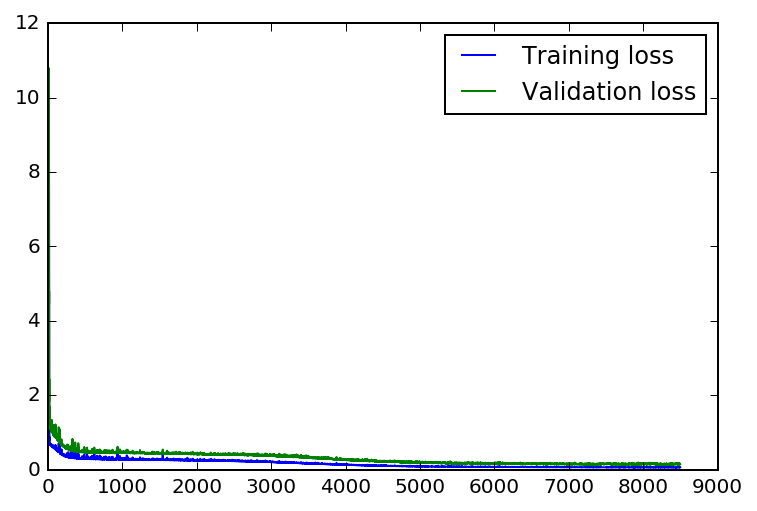

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

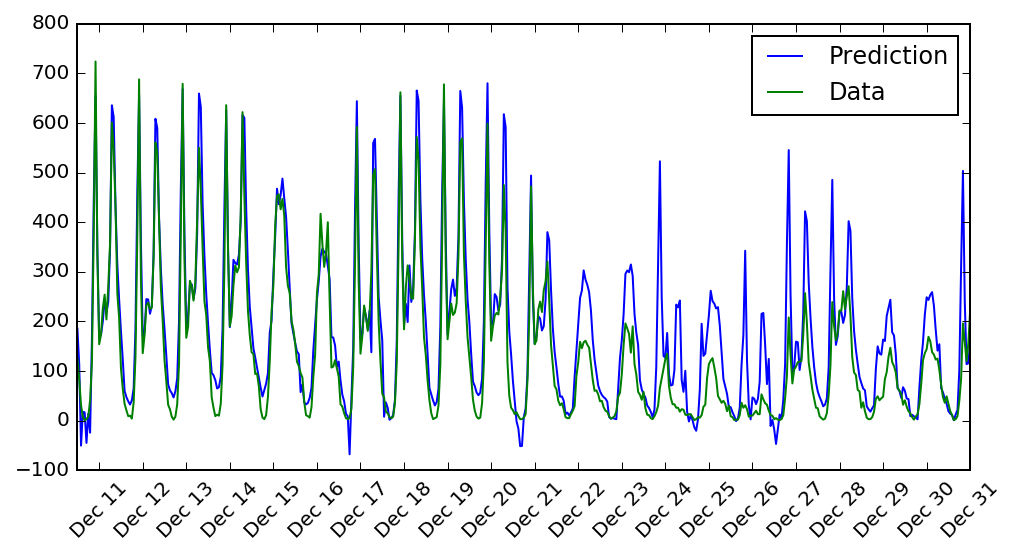

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

Loss in accuracy due to the number of hidden layers (only 1 hidden layer)
